In [1]:
import xarray as xr
import pandas as pd
import numpy as np 
import dask as da
import shapely as shp
from scipy.interpolate import interp1d
from pathlib import Path
import rioxarray as rxr

In [2]:
path = Path.cwd().parent / 'data' / 'in'
path

PosixPath('/home/hmack/Development/onehealth-model-backend/data/in')

# get data

In [10]:
data = xr.open_dataset(path / "ERA5land_global_t2m_dailyStats_mean_01Deg_2024_08_data.nc", chunks='auto')
data

<xarray.Dataset> Size: 804MB
Dimensions:     (valid_time: 31, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * valid_time  (valid_time) datetime64[ns] 248B 2024-08-01 ... 2024-08-31
  * longitude   (longitude) float64 29kB -179.9 -179.8 -179.7 ... 179.9 180.0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 804MB dask.array<chunksize=(16, 902, 1800), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-07T15:15 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
temp_data = xr.Dataset(pd.read_csv(path / "R0_pip_stats.csv")) 
temp_data

<xarray.Dataset> Size: 14kB
Dimensions:      (dim_0: 451)
Coordinates:
  * dim_0        (dim_0) int64 4kB 0 1 2 3 4 5 6 ... 444 445 446 447 448 449 450
Data variables:
    Temperature  (dim_0) float64 4kB 0.0 0.1 0.2 0.3 0.4 ... 44.7 44.8 44.9 45.0
    Median_R0    (dim_0) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Species      (dim_0) object 4kB 'pip.' 'pip.' 'pip.' ... 'pip.' 'pip.'

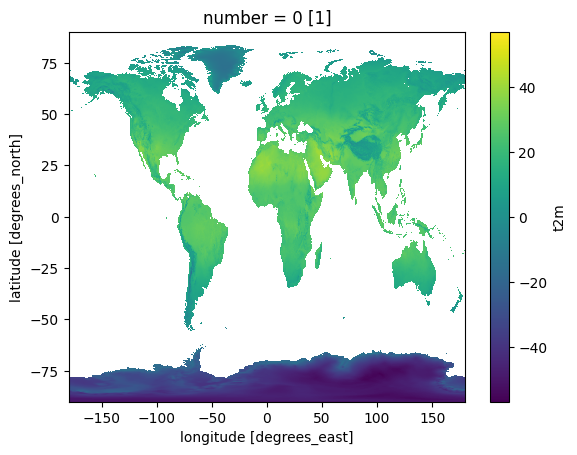

In [11]:
data['t2m'].mean(dim='valid_time').plot(cmap='viridis')

# interpolation function

In [ ]:
temps = np.arange(0., 45.1, 0.1)
valid = (~np.isnan(temp_data.Median_R0) & (temp_data.Temperature >= 0.0) & (temp_data.Temperature <= 45.1 )).values

# interp1d is deprecated, but it works and does what we need. 
# replacing this with a callback to numpy.interp is unnecessarily complicated, since 
# we need a function at the end, not the array directly.
r0_pip_fun = interp1d(
    temp_data.Temperature[valid].values, 
    temp_data.Median_R0[valid].values, 
    bounds_error=False, 
    fill_value=0.0, 
    kind='linear'
)


In [8]:
print(f"Min: {data['t2m'].min().values}")
print(f"Max: {data['t2m'].max().values}")
print(f"Mean: {data['t2m'].mean().values}")

Min: -67.10018920898438
Max: 44.2342529296875
Mean: 0.909875214099884


# apply the function to the data

In [ ]:
r0_map = xr.apply_ufunc(
    r0_pip_fun, 
    data['t2m'], 
    dask="allowed", 
    input_core_dims=[[]],
    output_core_dims=[[]],
    vectorize=True,
)
r0_map

<xarray.DataArray 't2m' (valid_time: 31, latitude: 1801, longitude: 3600)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], shape=(31, 1801, 3600))
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * valid_time  (valid_time) datetime64[ns] 248B 2024-08-01 ... 2024-08-31
  * longitude   (longitude) float64 29kB -179.9 -179.8 -179.7 ... 179.9 180.0

In [ ]:
print(f"Min: {r0_map.min().values}")
print(f"Max: {r0_map.max().values}")
print(f"Mean: {r0_map.mean().values}")

Min: 0.0
Max: 1.0
Mean: 0.2346002769245347


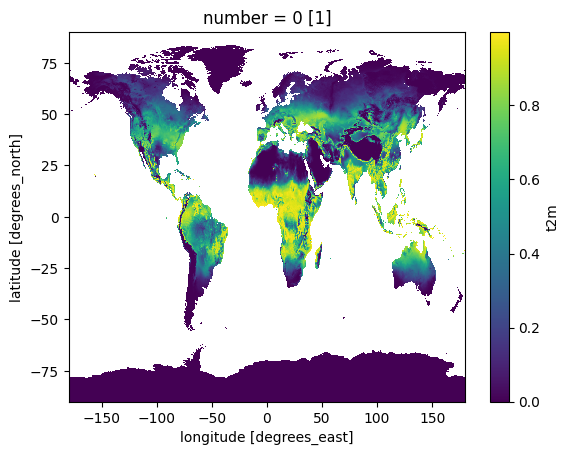

In [ ]:
r0_map.mean(dim='valid_time').plot(cmap='viridis')

This looks fundamentally different from the version of R

In [18]:
import eurostat as eust

AttributeError: module 'eurostat' has no attribute 'get_nuts_geometry'

In [ ]:
get_eurostat_geospatial(resolution = 10,
                                    nuts_level = 3, 
                                    year = 2024) 